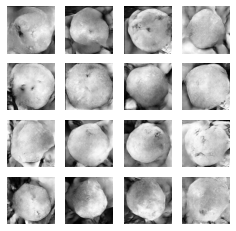

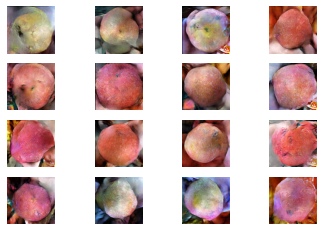

Time for epoch 112 is 57.98307967185974 sec


In [ ]:
import tensorflow as tf
tf.__version__

# 用于生成 GIF 图片
#!pip install imageio

#import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from PIL import Image
import cv2
import csv
import os
from skimage import io
import PIL
from tensorflow.keras import layers
import time
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from IPython import display

train_str = "train.csv"
train_img_dir = "C1-P1_Train/" 
csvfile = open(train_str)
reader = csv.reader(csvfile)
labels_pic = []
labels_level = []
for line in reader:
    labels_pic.append(line[0])
    labels_level.append(line[1])
csvfile.close() 
labels_pic.pop(0)
labels_level.pop(0)
picnum = len(labels_pic)
print("芒果圖片數量: ",picnum)
    
train_images = []

for i in range(len(labels_pic)):
  if labels_level[i]=="C":

    img = io.imread(train_img_dir + labels_pic[i])
    #img = cv2.imread(train_img_dir + labels_pic[i])
    img = cv2.resize(img,(128,128),interpolation=cv2.INTER_LINEAR)
    res = img[:, :, [2, 1, 0]]
    # flip image
    img_flip0=cv2.flip(res,0)
    img_flip1=cv2.flip(res,1)
    img_flip2=cv2.flip(res,-1)
    img_flip0 = img_flip0[:, :, [2, 1, 0]]
    img_flip1 = img_flip1[:, :, [2, 1, 0]]
    img_flip2 = img_flip2[:, :, [2, 1, 0]]
    train_images.append(np.asarray(img_flip0))
    train_images.append(np.asarray(img_flip1))
    train_images.append(np.asarray(img_flip2))
    # rotate image
    (h, w) = res.shape[:2] 
    center = (w // 2, h // 2)
    M_90 = cv2.getRotationMatrix2D(center, 90, 1.0)
    M_270 = cv2.getRotationMatrix2D(center, 270, 1.0)  
    rotated_img_90 = cv2.warpAffine(res, M_90, (w, h))
    rotated_img_270 = cv2.warpAffine(res, M_270, (w, h))
    rotated_img_90 = rotated_img_90[:, :, [2, 1, 0]]
    rotated_img_270 = rotated_img_270[:, :, [2, 1, 0]]
    train_images.append(np.asarray(rotated_img_90))
    train_images.append(np.asarray(rotated_img_270))
    res = res[:, :, [2, 1, 0]]
    if i < 5:
        plt.imshow(res)
        plt.show()
    train_images.append(np.asarray(res))

train_images = np.array(train_images)
print(train_images.shape)

datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(train_images)

plt.imshow(train_images[0])
plt.show()
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 128, 128, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将圖片normalize到[-1, 1]
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 128

# 批量化和打亂數據
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 生成器
def make_generator_model():
    model = tf.keras.Sequential()
    size = 8
    model.add(layers.Dense(size*size*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((size, size, 512)))
    assert model.output_shape == (None, size, size, 512) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, size*2, size*2, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, size*4, size*4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, size*8, size*8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, size*16, size*16, 3)
    
    return model

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0]*127.5 + 127.5)
plt.show()

# 判別器
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# 定義 loss function, optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './checkpoint_C'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()
      

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i]* 127.5 + 127.5
      img = array_to_img(img)
      plt.imshow(img)
      plt.axis('off')

  plt.savefig('GAN_IMAGE_C/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# 恢復最新的checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

train(train_dataset, EPOCHS)

# 使用 epoch 数生成单张图片
def display_image(epoch_no):
  return PIL.Image.open('GAN_IMAGE_C/image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)
